# Проект
- Данные сервиса-агрегатора доставки еды «Всё.из.кафе»
- Необходимо помочь бизнесу ответить на следующие вопросы:
    - Как ведут себя пользователи? Как наиболее эффективно выстроить работу с ними, чтобы они продолжали пользоваться продуктом?
    - Какой путь проходят пользователи в сервисе? Где «проваливаются»?
    - Как улучшить взаимодействие с партнёрами-ресторанами?

# План работы
- Общий анализ данных
- Сегментировать пользователей по признакам и их комбинациям
- Найти группы "уходящих" пользователей
- RFM-анализ
- Провести поиск "клиентов-китов"
- Провести анализ по биннингу данных
- Проанализировать воронку пользователей


In [25]:
# Загружаем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/insides_data.csv')

# Общие данные

In [3]:
print('Инфорация о df')
df.info()
print('\nПервые 5 строк')
display(df.head())
print('\nПропущенные значения')
print(df.isnull().sum())
print('\nДубликаты')
print(df.duplicated().sum())

Инфорация о df
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205510 entries, 0 to 205509
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   visitor_uuid  205510 non-null  object 
 1   user_id       205510 non-null  float64
 2   device_type   205510 non-null  object 
 3   city_id       205510 non-null  int64  
 4   source        205510 non-null  object 
 5   first_date    205510 non-null  object 
 6   visit_id      205510 non-null  int64  
 7   event         205510 non-null  object 
 8   datetime      205510 non-null  object 
 9   rest_id       166915 non-null  object 
 10  object_id     21308 non-null   float64
 11  order_id      7008 non-null    float64
 12  revenue       7008 non-null    float64
 13  delivery      7008 non-null    float64
 14  commission    21308 non-null   float64
dtypes: float64(6), int64(2), object(7)
memory usage: 23.5+ MB

Первые 5 строк


,visitor_uuid,user_id,device_type,city_id,source,first_date,visit_id,event,datetime,rest_id,object_id,order_id,revenue,delivery,commission
0,01b5da38-3022-48ff-87c0-5519247fef1b,567317.0,Desktop,6,Source_B,2021-05-01,171481813,authorization,2021-05-01 16:07:53,NaN,NaN,NaN,NaN,NaN,NaN
1,01b5da38-3022-48ff-87c0-5519247fef1b,567317.0,Desktop,6,Source_B,2021-05-01,171481813,reg_page,2021-05-01 16:09:16,NaN,NaN,NaN,NaN,NaN,NaN
2,01b5da38-3022-48ff-87c0-5519247fef1b,567317.0,Desktop,6,Source_B,2021-05-01,171481813,confirm_phone,2021-05-01 16:09:19,NaN,NaN,NaN,NaN,NaN,NaN
3,01b5da38-3022-48ff-87c0-5519247fef1b,567317.0,Desktop,6,Source_B,2021-05-01,171481813,login,2021-05-01 16:09:23,NaN,NaN,NaN,NaN,NaN,NaN
4,01b5da38-3022-48ff-87c0-5519247fef1b,567317.0,Desktop,6,Source_B,2021-05-01,171481813,main_page,2021-05-01 16:09:34,2c6095730b514c189ee41c65f03febc3,NaN,NaN,NaN,NaN,NaN



Пропущенные значения
visitor_uuid         0
user_id              0
device_type          0
city_id              0
source               0
first_date           0
visit_id             0
event                0
datetime             0
rest_id          38595
object_id       184202
order_id        198502
revenue         198502
delivery        198502
commission      184202
dtype: int64

Дубликаты
0


- Датафрейм содержит 205,510 записей событийной аналитики пользователей сервиса доставки еды за 2021 год с полной информацией по базовым атрибутам (пользователи, устройства, источники трафика)
- В коммерческих данных значительные пропуски (7.000 записей с revenue, 21.000 записей с commission), что указывает на типичную воронку конверсии где большинство пользователей просматривают контент, но лишь малая часть совершает покупки
- Данные чистые (нет дубликатов), структурированы по событиям и готовы для анализа пользовательских путей, конверсии и поведенческих паттернов

In [4]:
# Округляем datetime до недель и конвертируем все временные величины в timestamp
df['datetime_week'] = pd.to_datetime(df['datetime']).dt.to_period('W').dt.to_timestamp()
df['first_date'] = pd.to_datetime(df['first_date']) 

In [5]:
# Формируем столбцы для таблицы по группам активности
groups = ['device_type', 'city_id', 'source', 'rest_id']

# Сводная таблица по группам активности
for column in groups:
    print(f'Столбец {column}')
    count = df[column].value_counts()
    percent = df[column].value_counts(normalize=True) * 100

    result = pd.DataFrame({
        'Количество': count,
        'Процент': percent.round(2)
    })
    print(result)
    print('\n' + '*'*30 + '\n')

Столбец device_type
             Количество  Процент
device_type                     
Desktop          159119    77.43
Mobile            46391    22.57

******************************

Столбец city_id
         Количество  Процент
city_id                     
6            188305    91.63
5             10617     5.17
4              2844     1.38
2              2517     1.22
1               844     0.41
3               383     0.19

******************************

Столбец source
          Количество  Процент
source                       
organic       101565    49.42
Source_B       61435    29.89
Source_C       32558    15.84
Source_A        9952     4.84

******************************

Столбец rest_id
                                  Количество  Процент
rest_id                                              
8d9fb9d5992f400eaf02660973a66adf       13828     8.28
55d4027ac83e438f9f893892f6903409       13038     7.81
1be5a933aab34fbab594bebba48e976e        8188     4.91
1d6bb74687104fa19539

- Описание распределения активности пользователей
    - Device Type: Доминирует Desktop (77%) над Mobile (22%), что нетипично для современных сервисов доставки еды, где обычно преобладает мобильный трафик. Это может указывать на проблемы с мобильным приложением или его отсутствие.
    - География: Сильная концентрация в городе 6 (90% активности пользователей), остальные города значительно меньше. Классическое распределение с одним доминирующим регионом.
    - Источники трафика: Органический трафик составляет половину (50%), что хорошо для бренда. Source_B показывает неплохие результаты (29.5%), Source_A наименее эффективен (5%)
    - 2 ресторана открываются от всех по количеству активности, связанной с ними

# Распределение дохода по группам в течении недель

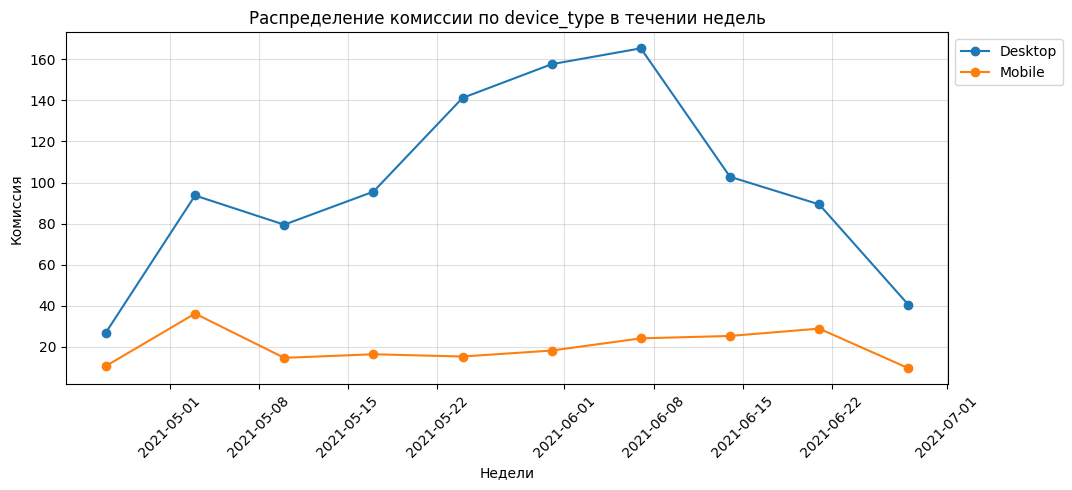

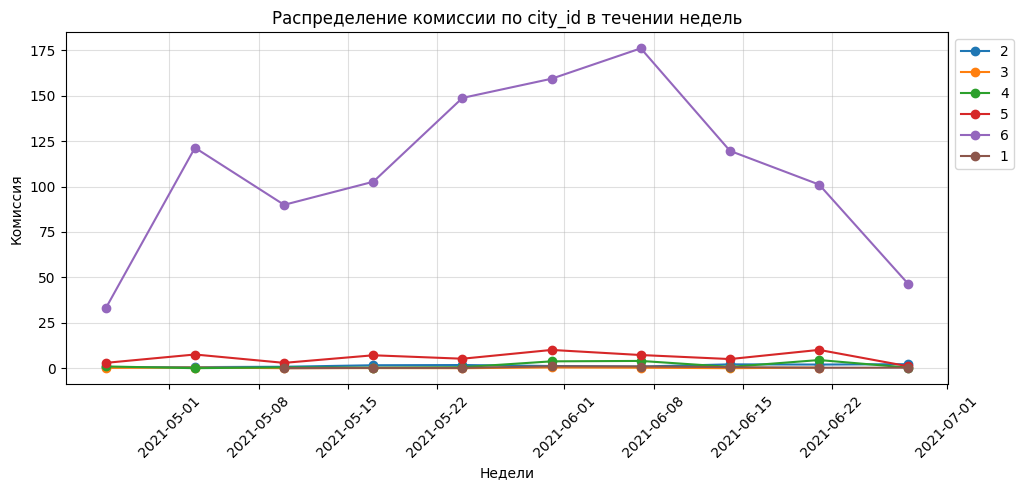

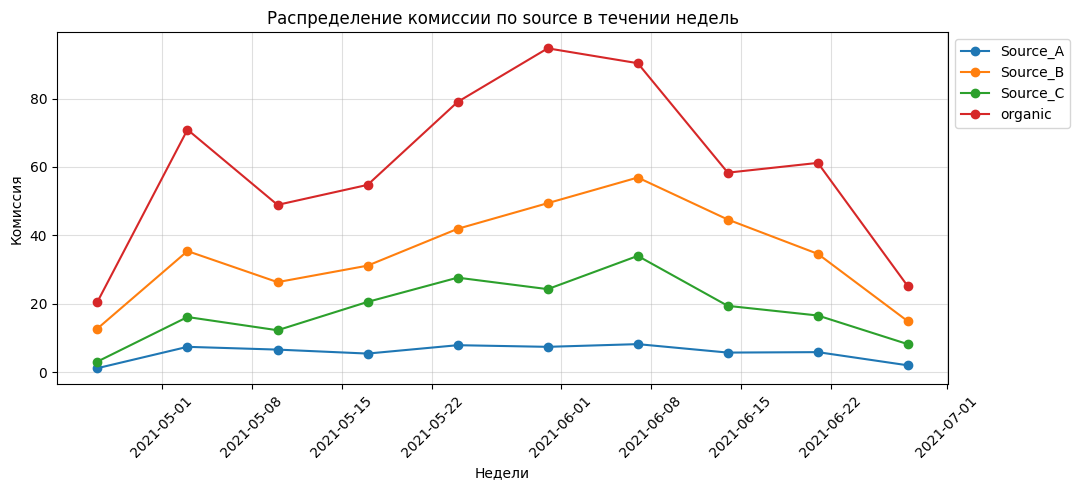

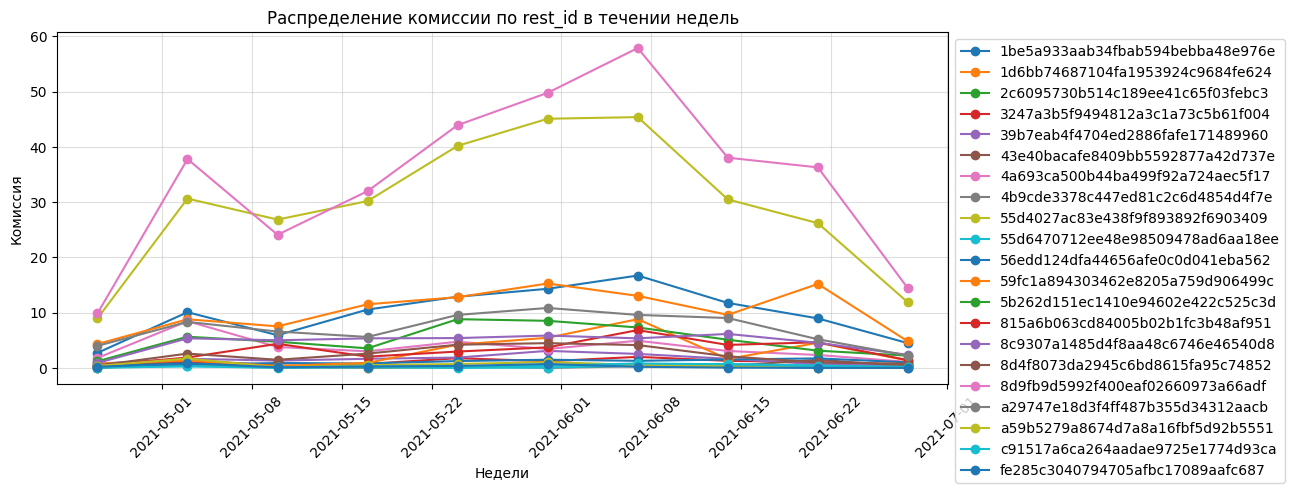

In [6]:
# Визуализация распределения комиссии по группам в течении недель
for column in groups:
    plot_df = df.groupby(['datetime_week', column], as_index=False)['commission'].sum()
    plt.figure(figsize=(10, 5))

    for i in plot_df[column].unique():
        df_segment = plot_df[plot_df[column] == i]
        plt.plot(df_segment['datetime_week'], df_segment['commission'], label=i, marker = 'o')
    plt.title(f'Распределение комиссии по {column} в течении недель')
    plt.xlabel('Недели')
    plt.ylabel('Комиссия')
    plt.legend()
    plt.grid(alpha=0.4)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.show()


Наблюдения
- По устройствам: Desktop показывает более волатильное поведение с пиком ~165, в то время как Mobile демонстрирует более стабильную динамику на уровне 15-30 - десктоп определяет всю статистику
- По городам: Город 6 полностью определяет общий тренд, остальные города показывают минимальную активность и практически не влияют на общую картину - следует изучить его подробнее
- По источникам: Органический трафик наиболее волатилен с пиком ~95, Source_B показывает стабильный рост до ~55, Source_A остается на минимальном уровне - все показатели имеют тенденцию к падению
- По ресторанам: 2 ресторана, принсоящих максимальный доход от комиссии, начали показывать снижение доходности в то же время как и остальные метрики, возможно это наш корень проблемы падающих показателей
Попробуем определить сегмент пользователкей который начал "уходить" из приложения

In [7]:
# Функция для визуализации коммиссии по сегменту
def segment_plot(data, segment_attr):
    df_segment = data.groupby(['datetime_week', segment_attr])['commission'].sum().reset_index()
    segments = df_segment[segment_attr].unique()

    plt.figure(figsize=(12, 6))
    for segment in segments:
        df_plot = df_segment[df_segment[segment_attr] == segment]
        plt.plot(df_plot['datetime_week'], df_plot['commission'], label=segment)
    
    plt.legend()
    plt.title(f'Комиссия по {segment_attr}')
    plt.xlabel('Неделя')
    plt.ylabel('Комиссия')
    plt.xticks(rotation=45)
    plt.show()

In [8]:
# Выделяем призак принадлежности к самому прибыльному городу или нет 
city_commission_top1 = (
    df
    .groupby('city_id')['commission']
    .sum()
    .nlargest(1))

df['city'] = df['city_id'].apply(
    lambda x: x if x in (city_commission_top1.index) else 'other')

In [9]:
# Группировка данных по ресторанам и расчет общей комиссии
rest_top_share = df.groupby('rest_id', as_index=False)['commission'].sum().sort_values(by='commission', ascending=False)
# Расчет суммы комиссий топ-2 ресторанов
rest_top2_total = rest_top_share['commission'].head(2).sum()
# Расчет общей суммы комиссий всех ресторанов
rest_top_total = rest_top_share['commission'].sum()
# Расчет процентной доли топ-2 ресторанов
rest_top2_share = rest_top2_total / rest_top_total * 100

print(f'Доля топ-2 ресторанов: {rest_top2_share:.2f}% от всей выручки')

Доля топ-2 ресторанов: 53.71% от всей выручки


# Поиск "уходящих" пользователей

In [10]:
# Получаем ID топ-2 ресторанов (уже отсортированы по убыванию)
top2_rest_ids = rest_top_share['rest_id'].head(2)

# Фильтруем основной датафрейм для будущей работы
df_rests = df[df['rest_id'].isin(top2_rest_ids)].copy()


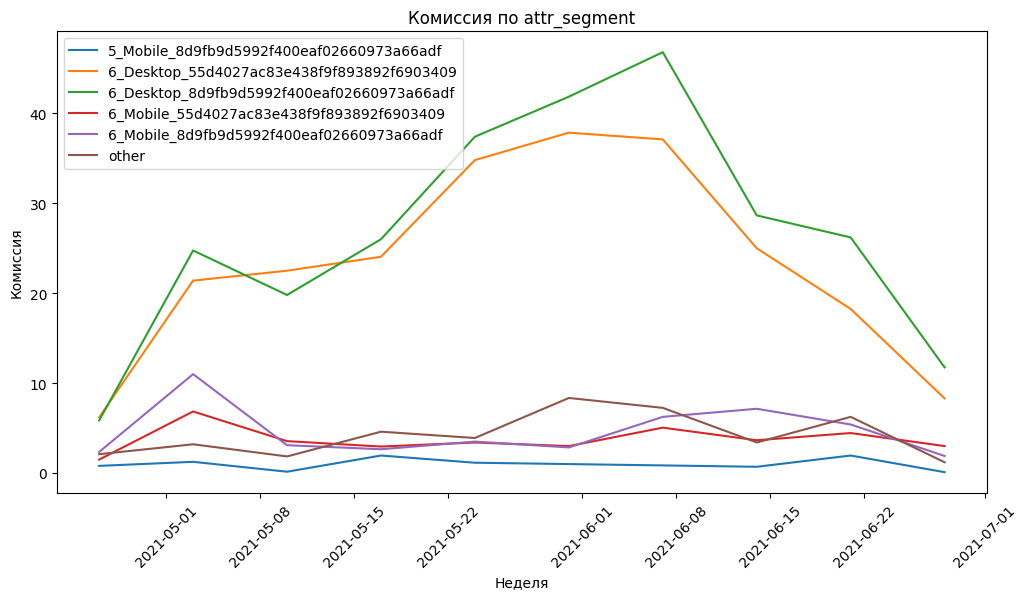

In [11]:
# Задаём названия исходных признаков,
# которые будем склеивать в единый «сегмент».
first_attr = 'city_id' 
second_attr = 'device_type'
third_attr = 'rest_id'
combine_attr = first_attr + '_' + second_attr + '_' + third_attr

# Строим новый столбец с композитным ключом
df_rests[combine_attr] = (
    df_rests[first_attr].astype(str) + '_' + 
    df_rests[second_attr].astype(str) + '_' + 
    df_rests[third_attr].astype(str))

# Суммируем выручку (commission) по каждому композитному ключу
# и оставляем только 5 крупнейших сегментов
combined_commission = (
    df_rests
    .groupby(combine_attr)['commission']
    .sum()
    .nlargest(5))

# Формируем финальный сегмент-лейбл для графика:
# если строка попала в ТОП-4 — оставляем ключ, иначе помечаем 'other'
df_rests['attr_segment'] = df_rests[combine_attr].apply(
    lambda x: x if x in (combined_commission.index) else 'other')

# Строим график
segment_plot(df_rests, 'attr_segment')

Проверим этот принцип на всех данных, а не только на топ-2 ресторанах по доходности

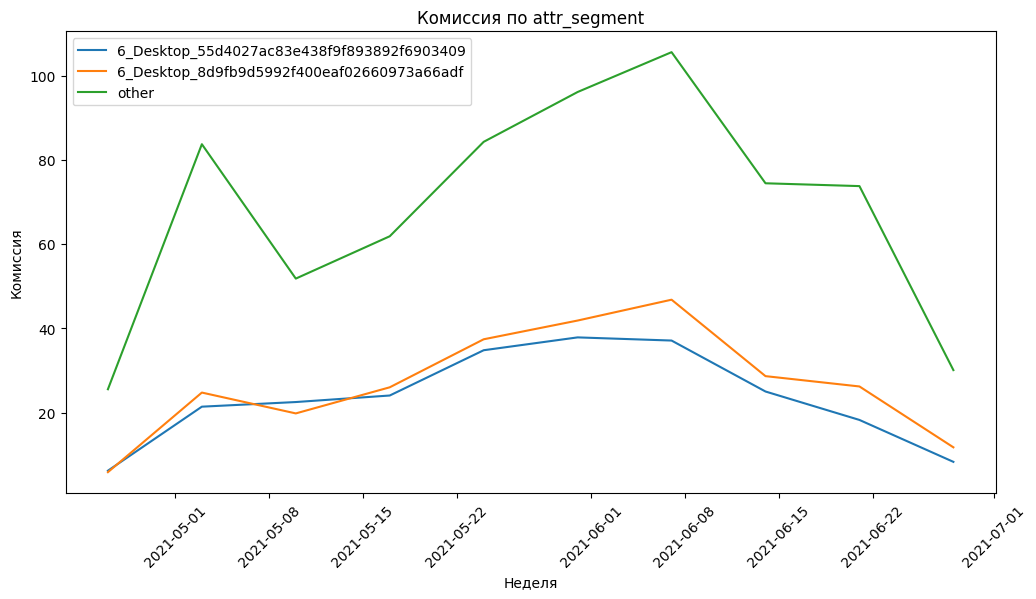

In [12]:
df_all_rests = df.copy()

# Строим новый столбец с композитным ключом
df_all_rests[combine_attr] = (
    df_all_rests[first_attr].astype(str) + '_' + 
    df_all_rests[second_attr].astype(str) + '_' + 
    df_all_rests[third_attr].astype(str))

# Суммируем выручку (commission) по каждому композитному ключу
# и оставляем только 2 крупнейших сегмента
combined_commission_all = (
    df_all_rests
    .groupby(combine_attr)['commission']
    .sum()
    .nlargest(2))

# Формируем финальный сегмент-лейбл для графика:
# если строка попала в ТОП-2— оставляем ключ, иначе помечаем 'other'
df_all_rests['attr_segment'] = df_all_rests[combine_attr].apply(
    lambda x: x if x in (combined_commission_all.index) else 'other')

# Строим график
segment_plot(df_all_rests, 'attr_segment')

Визуализация общей доходности приложения

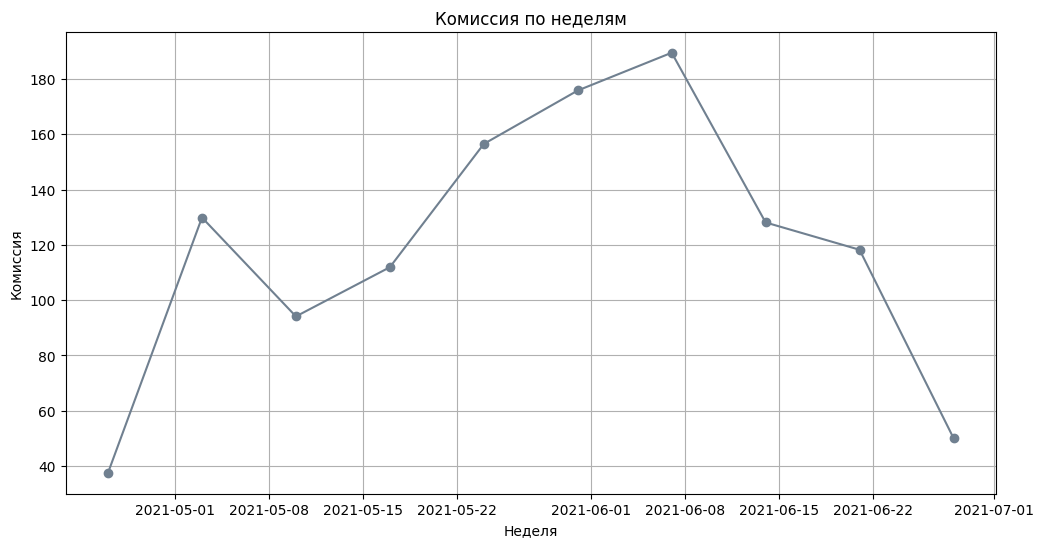

In [13]:
p = df.groupby('datetime_week')['commission'].sum().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(p['datetime_week'], p['commission'], marker = 'o', color='slategrey')
plt.title('Комиссия по неделям')
plt.xlabel('Неделя')
plt.ylabel('Комиссия')
plt.grid(True)
plt.show()


## Промежуточные наблюдения

- Desktop пользователи в городе 6 генерируют наибольшую выручку, но демонстрируют высокую волатильность и резкое падение активности в конце периода
- Mobile пользователи показывают более стабильное, но менее интенсивное потребление
- 2 топовых ресторана показывают динамику к ухудшению выручки только на десктопе и только в городе 6
- При этом общая тенденция у всех остальных ресторанов выглядит таким же образом в соответствии с общим падением выручки приложения
- Первый график (топ-2 ресторана):
    - Более стабильные и предсказуемые тренды
    - Пик и спад (или проблемы продукта) после июня 2021 года
    - Максимальная комиссия достигает ~45 единиц
    - Плавное снижение после пика без резких провалов

- Второй график (все рестораны):
    - Значительно более волатильная динамика
    - Экстремальный пик до 70 единиц у сегмента "other"
    - Резкие колебания и непредсказуемые скачки
    - Более хаотичное поведение сегментов

# RFM-анализ

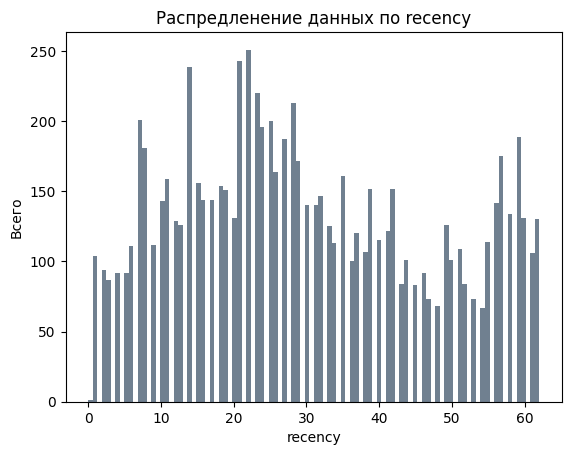

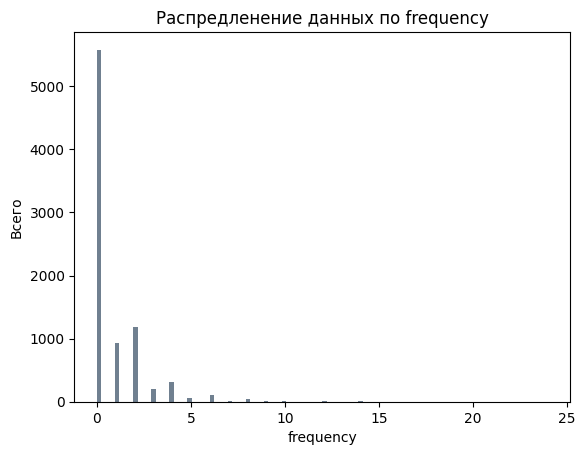

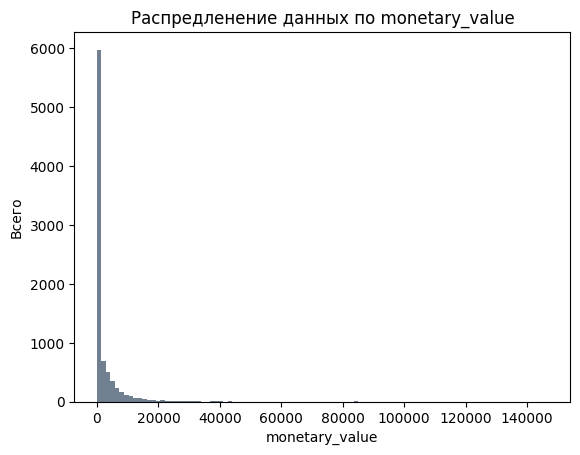

In [14]:
# Считаем давность посещения клиента
df['order_recency'] = (pd.to_datetime('2021-07-03') - pd.to_datetime(df['datetime'])).dt.days

# Считаем давность, частоту и сумму всех покупок
df_rfm = df.groupby('user_id').agg(
    recency = ('order_recency', 'min'),
    frequency = ('order_id', 'count'),
    monetary_value = ('revenue', 'sum'))
    
# Визуализация
for i in df_rfm.columns:
    plt.hist(df_rfm[i], bins=100, color='slategrey')
    plt.title(f'Распредленение данных по {i}')
    plt.xlabel(i)
    plt.ylabel('Всего')
    plt.show()

- Давность: распределение данных крайне стабильное - можно использовать деление данных по равным частям 
- Частота: данные сильно смещены в одну сторону, лучше использовать деление по квартилям, но данные крайне дискретны, а не непрерывны, значит лучше применить ручное деление 
- Сумма заказа: сильно смещены в одну сторону, но для формирования четких границ групп лучше использовать ручные границы

In [15]:
# RFM
df_rfm['r'] = pd.cut(df_rfm['recency'], bins=3, labels=[3, 2, 1])

df_rfm['f'] = pd.cut(df_rfm['frequency'], [0, 1, 5, 25], labels=[1, 2, 3], include_lowest=True)

df_rfm['m'] = pd.cut(df_rfm['monetary_value'], [0, 5000, 15000, 150000], labels=[1, 2, 3], include_lowest=True)

df_rfm['rfm'] = df_rfm['r'].astype(str) + df_rfm['f'].astype(str) + df_rfm['m'].astype(str)

# Считаем итоговое количество клиентов в каждой группе
rfm_counts = df_rfm['rfm'].value_counts().reset_index()

# Добавляем процентное соотношение
rfm_counts['percentage'] = (rfm_counts['count'] / rfm_counts['count'].sum() * 100).round(2)

rfm_counts

,rfm,count,percentage
0,211,2583,30.49
1,311,2069,24.42
2,111,1780,21.01
3,221,331,3.91
4,222,309,3.65
5,321,289,3.41
6,322,265,3.13
7,121,254,3.00
8,122,210,2.48
9,233,58,0.68


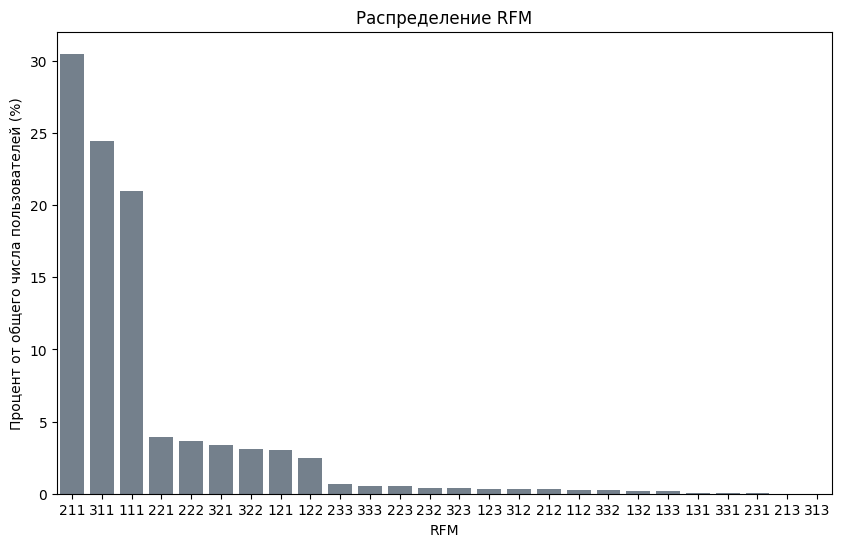

In [16]:
plt.figure(figsize=(10, 6))
sns.barplot(rfm_counts, x='rfm', y='percentage', color='slategrey')
plt.xlabel('RFM')
plt.ylabel('Процент от общего числа пользователей (%)')
plt.title('Распределение RFM')
plt.show()

Основные выводы по распределению клиентов:

- Три доминирующих сегмента составляют около 76% всей клиентской базы. Самый крупный сегмент (211) включает 30,49% пользователей — это клиенты, которые заказывали относительно давно, но делали это часто, при этом тратили небольшие суммы
- Второй по величине сегмент (311) объединяет 24,42% клиентов — недавних пользователей с высокой частотой заказов, но также с низкими чеками. 
- Третий значимый сегмент (111) составляет 21,01% — это наименее активные клиенты с редкими заказами и небольшими тратами
- Ключевая проблема — низкая монетизация. Практически все крупные сегменты характеризуются минимальной денежной ценностью (последняя цифра "1" в RFM-коде)
-Высокооплачиваемые клиенты (сегменты с индексом "3" по денежной ценности) составляют менее 1% каждый
- Это указывает на то, что большинство пользователей делают небольшие заказы, что может быть связано с высокой конкуренцией или недостаточной работой по увеличению среднего чека
- Такое распределение говорит о необходимости фокусироваться на увеличении частоты заказов у неактивных клиентов и повышении среднего чека у всех сегментов

# Поиск "китов"

/tmp/ipykernel_75441/563890213.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  segment_total = users_revenue.groupby('segment')['revenue'].sum().reset_index()


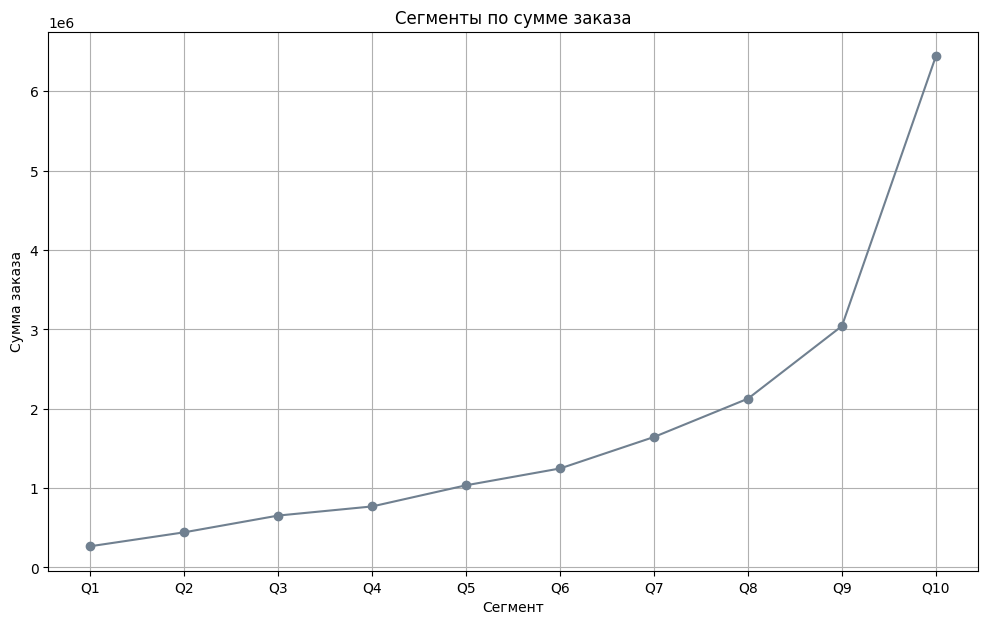

In [17]:
# Сегментация пользователей с заказом
df_orders = df[df['order_id'].notna()]

# Сегментация по пользователям
users_revenue = df_orders.groupby('user_id')['revenue'].sum().reset_index()

# Сегментация по сумме заказа
users_revenue['segment'] = (
    pd.qcut(users_revenue['revenue'], 
    q=10, 
    labels=[f'Q{i}' for i in range(1, 11)]))

segment_total = users_revenue.groupby('segment')['revenue'].sum().reset_index()

plt.figure(figsize=(12,7))
plt.plot(segment_total['segment'], segment_total['revenue'], marker='o', color='slategrey')
plt.title('Сегменты по сумме заказа')
plt.xlabel('Сегмент')
plt.ylabel('Сумма заказа')
plt.grid()
plt.show()

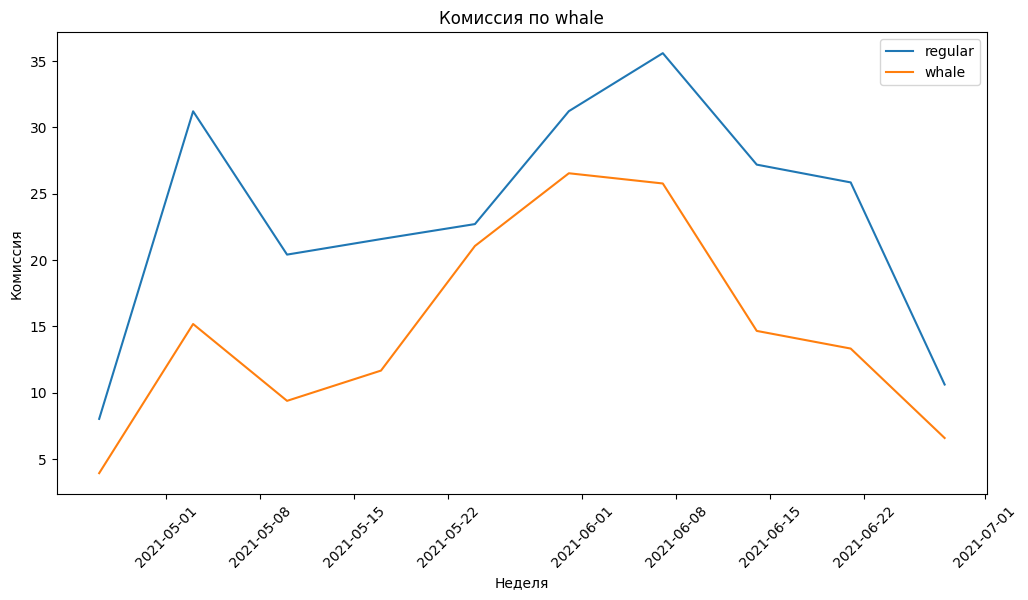

In [18]:
# Объединяем данные
df_orders_whales = pd.merge(
    df_orders,
    users_revenue,
    on='user_id',
    how='left')

# Создаем признак 
df_orders_whales['whale'] = df_orders_whales['segment'].apply(
    lambda x: 'whale' if x in ['Q9', 'Q10'] else 'regular')

segment_plot(df_orders_whales, 'whale')

Значение пользователей-китов для бизнеса
- Анализ сегментации клиентов подтверждает критическую важность пользователей-"китов" для финансовых показателей сервиса
- Топовый сегмент (Q10) генерирует заказы на сумму около 6,5 миллионов рублей, что кратно превышает показатели других сегментов 

Тревожный тренд снижения доходности
- Однако данные по комиссионным доходам выявляют серьезную проблему: даже высокодоходные whale-пользователи подвержены общему негативному тренду
- Комиссия от whale-сегмента снизилась с пика в 26-27 единиц до примерно 7 единиц к концу периода, что составляет падение более чем в 3 раза. 
- При этом regular-пользователи показали еще более драматичное снижение — с 35-36 до 11 единиц

# Биннинг по суммам заказов

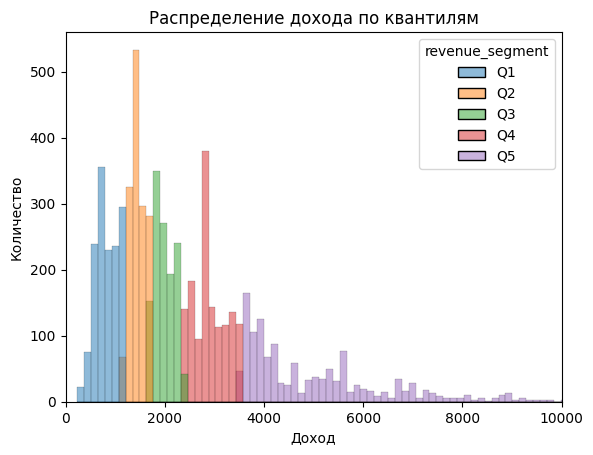

/tmp/ipykernel_75441/3445085638.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_segment = data.groupby(['datetime_week', segment_attr])['commission'].sum().reset_index()


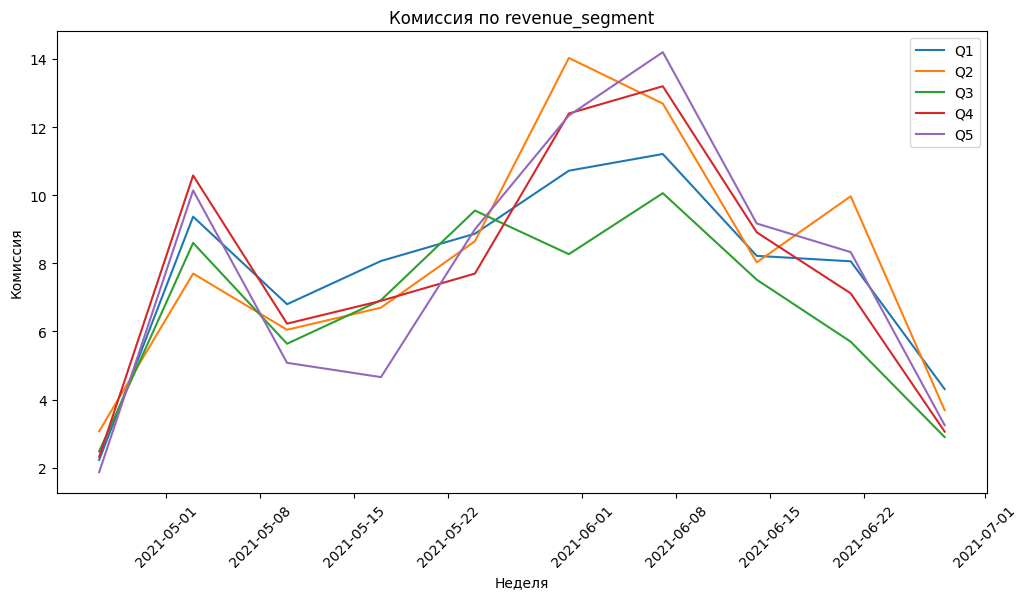

In [19]:
df_orders = df_orders.copy()
# Разделим данные на 5 квантилей по сумме заказа
df_orders['revenue_segment'] = pd.qcut(
    df_orders['revenue'],
    q=5,
    labels=['Q1', 'Q2', 'Q3', 'Q4', 'Q5'])

sns.histplot(df_orders, x='revenue', hue='revenue_segment', bins=300)
plt.title('Распределение дохода по квантилям')
plt.xlabel('Доход')
plt.ylabel('Количество')
plt.xlim(0, 10000)
plt.show()

segment_plot(df_orders, 'revenue_segment')

- Анализ распределения доходов по квантилям Q1-Q5 демонстрирует аналогичные закономерности, что и предыдущая сегментация пользователей. Гистограмма четко показывает логичное разделение заказов: Q1 концентрируется в диапазоне до 1000 рублей, Q2 достигает пика около 1500 рублей, средние сегменты (Q3-Q4) покрывают диапазон 1500-4000 рублей, а Q5 включает заказы свыше 4000 рублей.

- График временной динамики комиссии по сегментам выручки полностью укладывается в общий тренд снижения монетизации. Независимо от способа сегментации — по пользователям (whale/regular) или по суммам заказов (Q1-Q5) — наблюдается идентичная картина. Это указывает на системную проблему в бизнес-модели или внешних факторах, затрагивающих всю экосистему сервиса доставки, а не отдельные группы клиентов.

# Воронка пользователей

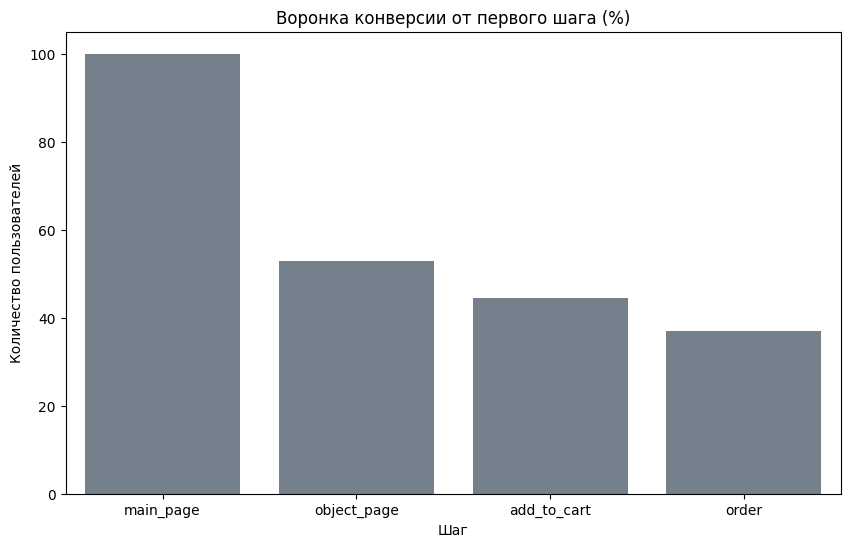

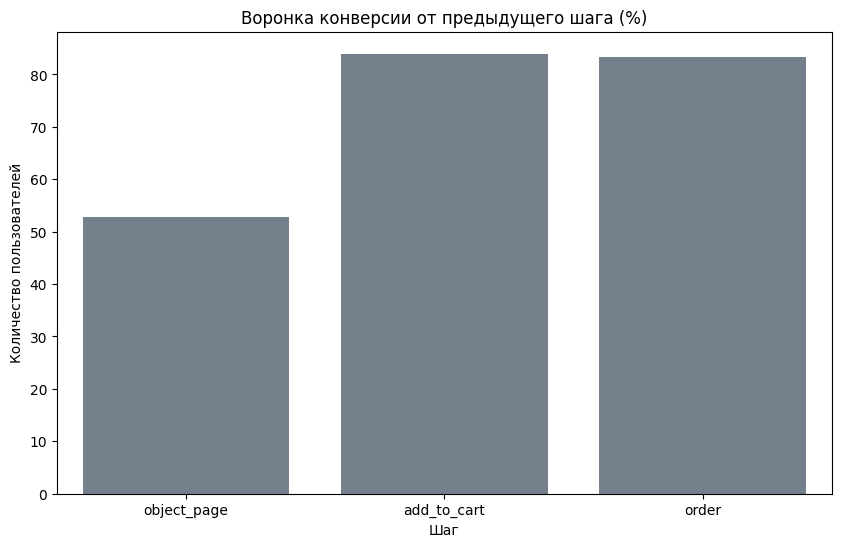

In [20]:
# Воронка конверсии
funnel_steps = ['main_page', 'object_page', 'add_to_cart', 'order']

# Подсчет количества пользователей на каждом шаге
funnel_count = (
    df[df['event'].isin(funnel_steps)]
    .groupby('event', as_index=False)['user_id']
    .nunique()
    .rename(columns={'event': 'step', 'user_id': 'total_users'})
    .sort_values(by='total_users', ascending=False))

# Конверсия от первого шага
funnel_count['conversion_from_first_%'] = (
    funnel_count['total_users'] / 
    funnel_count['total_users'].iloc[0] * 100).round(2)

# Конверсия от предыдущего шага
funnel_count['conversion_from_prev_%'] = (
    funnel_count['total_users'] / 
    funnel_count['total_users'].shift(1) * 100).round(2)

# Визуализация воронки
plt.figure(figsize=(10, 6))
sns.barplot(data=funnel_count, x='step', y='conversion_from_first_%', color='slategrey')
plt.title('Воронка конверсии от первого шага (%)')
plt.xlabel('Шаг')
plt.ylabel('Количество пользователей')
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(data=funnel_count[1:], x='step', y='conversion_from_prev_%', color='slategrey')
plt.title('Воронка конверсии от предыдущего шага (%)')
plt.xlabel('Шаг')
plt.ylabel('Количество пользователей')
plt.show()

#  Вывод

### Распределение данных и прибыльные категории клиентов
  -  **RFM-сегментация показывает концентрацию в низкочастотных сегментах:**
      - Сегмент 211 (30.49%) и 311 (24.42%) - это клиенты с низкой частотой заказов
      - Сегмент 111 (21.01%) - новые/неактивные клиенты
      - Проблема: 75% клиентской базы находится в неоптимальных сегментах

  -  **Устройства**: Данные показывают преобладание Desktop-трафика, что может указывать на:
      - Недооптимизированность мобильного приложения
      - Необходимость инвестиций в mobile-first подход

  -  **Географическое распределение:** Концентрация в определенных city_id требует анализа рентабельности по регионам

### Анализ оттока пользователей

  -  **Критическая точка оттока в воронке:**
      - main_page - object_page
      - Высокий процент пользователей не доходит до просмотра страниц с блюдами

  -  **Потенциальные причины оттока:**
      - Усложненный онбординг или его отсутствие после обноваления продукта
      - Возможные технические проблемы после обновлений в июне

### Стратегия работы с клиентами для удержания

  -  **Для сегмента 211-311 (основная масса клиентов):**
      - Внедрить программу лояльности с накопительными бонусами
      - Персонализированные пуш-уведомления с рекомендациями
      - Еженедельные email-рассылки с персональными специальными предложениями
      - Активировать скидки на повторные заказы

  -  **Для сегмента 111 (новые клиенты):**
      - Онбординг-сессия с обучающими материалами
      - Промокоды на первые 3 заказа с убывающей скидкой
      - Геймификация: челленджи и достижения

  -  **Реактивация неактивных клиентов:**
      - Щедрые промокоды для возвращения с персональными предложениями
      - Опросы для понимания причин неактивности
      - Временные эксклюзивные акции

### Улучшение взаимодействия с ресторанами-партнёрами

  -  **Оптимизация партнёрской сети:**
      - Анализ продуктивности ресторанов по метрикам: время приготовления, качество, отзывы
      - Программа обучения для ресторанов по цифровизации процессов

  -  **Финансовые инструменты:**
      - Пересмотр модели комиссий: снижение для высокорейтинговых, популярных или долгосотрудничающих ресторанов-партнёров
      - Совместные маркетинговые кампании с разделением затрат

  -  **Техническая интеграция:**
      - API для автоматической синхронизации меню и остатков продуктов или блюд (если имеется)
      - Мобильное приложение для партнёров с управлением заказами

**Ключевая рекомендация:** Сфокусироваться на упрощении первого пользовательского опыта и создании долгосрочных retention-механизмов для перевода клиентов в высокочастотные сегменты (12x, 13x, 23x).
